
#**Suryakanta Karan (M22AIE207) m22aie207@iitj.ac.in**

#Q2

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/surya/DL_Ops/Assignment_1')

Mounted at /content/drive


In [2]:
import os
import requests
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_curve, auc
import numpy as np


In [3]:
# Define the URL to download the data
url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

# Define the path to extract the data
extract_path = "/content/drive/MyDrive/surya/DL_Ops/Assignment_1"

# Download the zip file
response = requests.get(url)
zip_file_path = os.path.join(extract_path, "hymenoptera_data.zip")
with open(zip_file_path, "wb") as file:
    file.write(response.content)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

# Remove the zip file
os.remove(zip_file_path)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define dataset and dataloader
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

data_dir = os.path.join(extract_path, "hymenoptera_data")

image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True) for x in ['train', 'val']}

In [6]:
# Define model architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Function to evaluate metrics
def evaluate_metrics(original, reconstructed):
    mse = nn.MSELoss()(original, reconstructed)
    rmse = torch.sqrt(mse)
    ssim_score = ssim(original.permute(0, 2, 3, 1).detach().cpu().numpy(),
                      reconstructed.permute(0, 2, 3, 1).detach().cpu().numpy(),
                      multichannel=True)
    psnr_score = psnr(original.permute(0, 2, 3, 1).detach().cpu().numpy(),
                      reconstructed.permute(0, 2, 3, 1).detach().cpu().numpy())
    return mse.item(), rmse.item(), ssim_score, psnr_score

# train function
def train_model(model, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)
        running_loss = 0.0
        for inputs, _ in dataloaders['train']:
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        print(f"training Loss: {epoch_loss:.4f}")
    print("training complete")

# Function to visualize feature representations
def visualize_features(model, dataloader):
    features = []
    model.eval()
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            output = model.encoder(inputs)
            features.extend(output.view(output.size(0), -1).cpu().numpy())
    features = np.array(features)
    # PCA
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(features)
    # t-SNE
    tsne = TSNE(n_components=3)
    tsne_result = tsne.fit_transform(features)
    return pca_result, tsne_result

# Function to plot feature representations
def plot_features(pca_result, tsne_result, labels):
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=labels, cmap='viridis')
    ax1.set_title('PCA')
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    ax1.set_zlabel('Principal Component 3')
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], c=labels, cmap='viridis')
    ax2.set_title('t-SNE')
    ax2.set_xlabel('t-SNE Component 1')
    ax2.set_ylabel('t-SNE Component 2')
    ax2.set_zlabel('t-SNE Component 3')
    plt.show()

# Function to train MLP classifier
def train_mlp_classifier(features, labels, num_classes=2):
    classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
    classifier.fit(features, labels)
    return classifier

Task: Lab_to_RGB
--------------------
Epoch 1/10
----------
training Loss: 0.0643
Epoch 2/10
----------
training Loss: 0.0417
Epoch 3/10
----------
training Loss: 0.0298
Epoch 4/10
----------
training Loss: 0.0221
Epoch 5/10
----------
training Loss: 0.0171
Epoch 6/10
----------
training Loss: 0.0138
Epoch 7/10
----------
training Loss: 0.0117
Epoch 8/10
----------
training Loss: 0.0109
Epoch 9/10
----------
training Loss: 0.0101
Epoch 10/10
----------
training Loss: 0.0087
training complete


<ipython-input-4-b5e193edf08d>:32: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(original.permute(0, 2, 3, 1).detach().cpu().numpy(),


MSE: 0.0055, RMSE: 0.0742, SSIM: 0.9466, PSNR: 22.5959


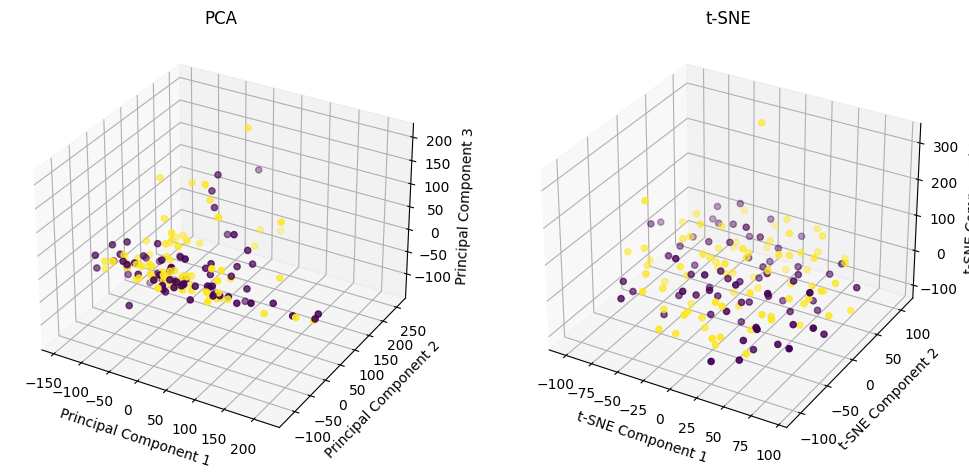

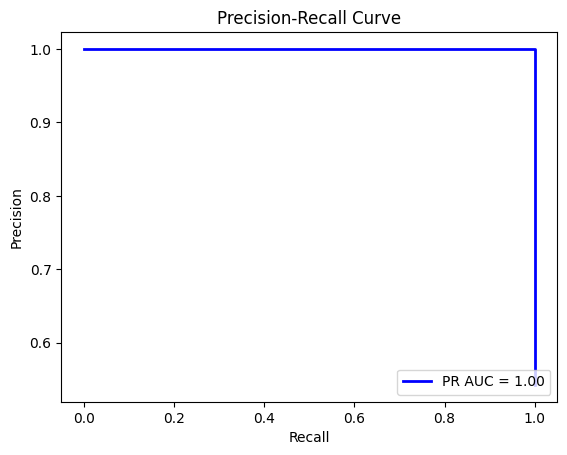

Task: RGB_to_negative
--------------------
Epoch 1/10
----------
training Loss: 0.0829
Epoch 2/10
----------
training Loss: 0.0567
Epoch 3/10
----------
training Loss: 0.0411
Epoch 4/10
----------
training Loss: 0.0298
Epoch 5/10
----------
training Loss: 0.0230
Epoch 6/10
----------
training Loss: 0.0182
Epoch 7/10
----------
training Loss: 0.0156
Epoch 8/10
----------
training Loss: 0.0134
Epoch 9/10
----------
training Loss: 0.0119
Epoch 10/10
----------
training Loss: 0.0107
training complete


<ipython-input-4-b5e193edf08d>:32: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(original.permute(0, 2, 3, 1).detach().cpu().numpy(),


MSE: 0.0071, RMSE: 0.0840, SSIM: 0.9301, PSNR: 21.5109


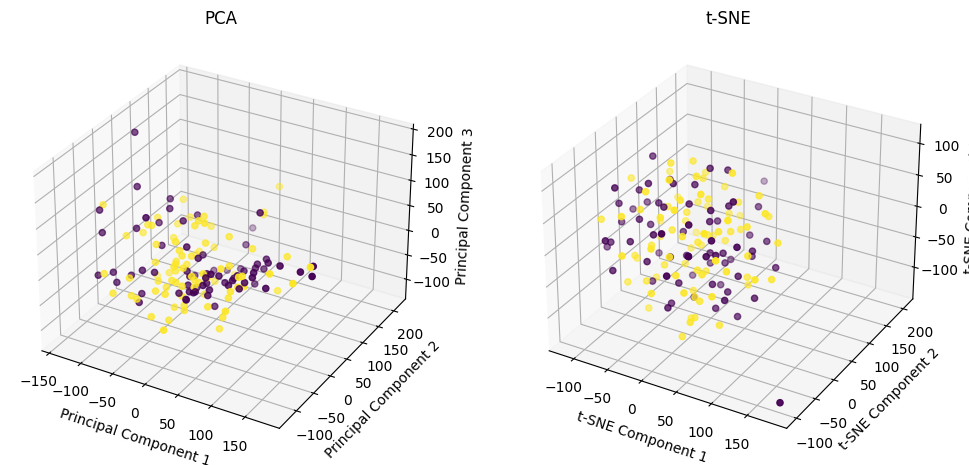

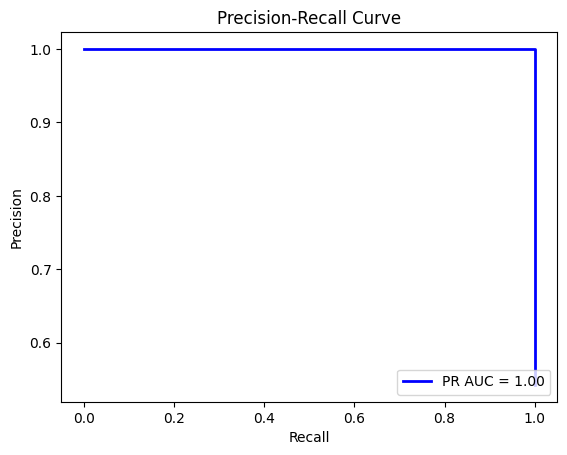

Task: RGB_to_horizontal_flip
--------------------
Epoch 1/10
----------
training Loss: 0.0718
Epoch 2/10
----------
training Loss: 0.0459
Epoch 3/10
----------
training Loss: 0.0318
Epoch 4/10
----------
training Loss: 0.0233
Epoch 5/10
----------
training Loss: 0.0187
Epoch 6/10
----------
training Loss: 0.0153
Epoch 7/10
----------
training Loss: 0.0127
Epoch 8/10
----------
training Loss: 0.0117
Epoch 9/10
----------
training Loss: 0.0099
Epoch 10/10
----------
training Loss: 0.0088
training complete


<ipython-input-4-b5e193edf08d>:32: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(original.permute(0, 2, 3, 1).detach().cpu().numpy(),


MSE: 0.0059, RMSE: 0.0769, SSIM: 0.9427, PSNR: 22.2762


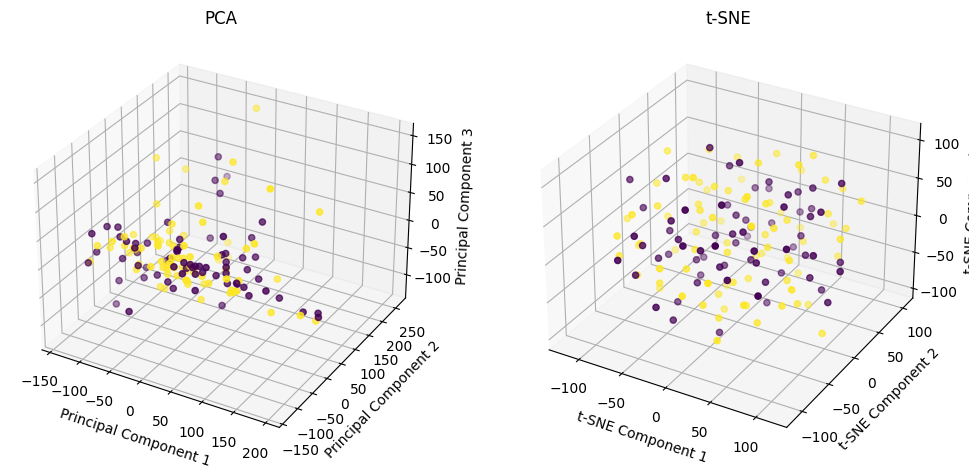

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


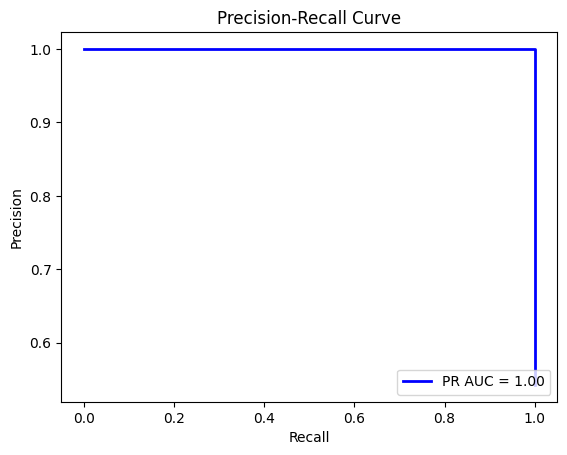

In [5]:
# Main function
def main():
    # Define transformations for tasks
    task_transforms = {
        'Lab_to_RGB': transforms.Compose([
            transforms.Lambda(lambda img: img.convert("RGB")),
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ]),
        'RGB_to_negative': transforms.Compose([
            transforms.Lambda(lambda img: 1 - img),
            transforms.ToTensor()
        ]),
        'RGB_to_horizontal_flip': transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.ToTensor()
        ])
    }

    tasks = ['Lab_to_RGB', 'RGB_to_negative', 'RGB_to_horizontal_flip']
    for task in tasks:
        print(f"Task: {task}")
        print('-' * 20)
        model = ConvAutoencoder().to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        train_loader = DataLoader(image_datasets['train'], batch_size=16, shuffle=True)
        test_loader = DataLoader(image_datasets['val'], batch_size=16, shuffle=False)
        # train model
        train_model(model, criterion, optimizer)
        # Evaluation
        test_images, _ = next(iter(test_loader))
        test_images = test_images.to(device)
        with torch.no_grad():
            reconstructed_images = model(test_images)
        mse, rmse, ssim_score, psnr_score = evaluate_metrics(test_images, reconstructed_images)
        print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, SSIM: {ssim_score:.4f}, PSNR: {psnr_score:.4f}")
        # Visualize features
        pca_result, tsne_result = visualize_features(model, test_loader)
        plot_features(pca_result, tsne_result, image_datasets['val'].targets)
        # train MLP classifier
        features = np.concatenate((pca_result, tsne_result), axis=1)
        labels = image_datasets['val'].targets
        classifier = train_mlp_classifier(features, labels)
        # Plot precision-recall curve
        y_score = classifier.predict_proba(features)
        precision, recall, _ = precision_recall_curve(labels, y_score[:, 1])
        pr_auc = auc(recall, precision)
        plt.figure()
        plt.plot(recall, precision, color='b', lw=2, label=f'PR AUC = {pr_auc:.2f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower right")
        plt.show()

if __name__ == "__main__":
    main()